<a href="https://colab.research.google.com/github/abhijeet3922/vision-RAG/blob/main/4_setup_vectordb_as_retriever.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Set up FAISS vector DB with Multi-vector Vision Embeddings**

This notebook demostrates setting up a vector database (FAISS as an example here) for multi-vector vision embeddings.

There are few concepts (workaround) used here:
- Use metadata fields of vector DB to store patch number, page number, file name.
- Flatten 2D embeddings (num_patches X 128) into 1D embeddings to store each patch as an entry in index.
- In retrieval process, match patches and then aggregate page number based on highest patch count to rank best matching pages.


Following are the code components for this notebook:
1. [Installing Libraries & Imports](#)
2. [Loading Visual Language Model (VLM): ColPali](#)
3. [Ingest PDF Data as Embeddings](#)
4. [Setup FAISS vector DB Index](#)
4. [Add Embeddings & Metadata Fields to Index](#)
5. [Retrieve best Matching Page from Vector DB](#)
6. [Load Multi-modal LLM: Qwen2.5-VL 3B](#)
7. [Prepare Prompt with Retrieved Page](#)
8. [Generate Answer: Model Inference](#)



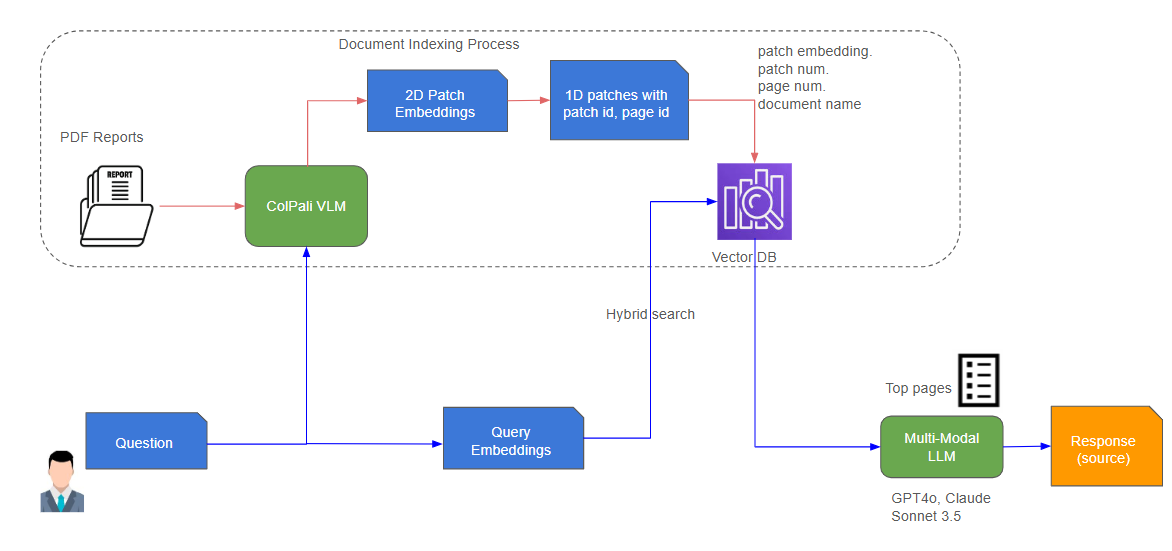

### 1. Install Libraries & Imports

In [ ]:
!pip install pdf2image
!pip install colpali-engine==0.3.9
!sudo apt-get install poppler-utils

!pip install faiss-cpu
!pip install langchain_community

In [ ]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from pdf2image import convert_from_path
from torch.utils.data import DataLoader
from colpali_engine.models import ColPali, ColPaliProcessor

### 2. Loading Visual Language Model (VLM): ColPali

In [ ]:
model_name = "vidore/colpali-v1.3"

model = ColPali.from_pretrained(
    model_name,
    torch_dtype=torch.bfloat16,
    device_map="auto",  # or "mps" if on Apple Silicon
).eval()

processor = ColPaliProcessor.from_pretrained(model_name)

### 3. Ingest PDF Data as Embeddings

In [ ]:
images = convert_from_path('/content/AT-T-2023.pdf')
print("Number of pages:", len(images))

In [ ]:
dataloader = DataLoader(images,
                        batch_size=1,
                        shuffle=False,
                        collate_fn=lambda x: processor.process_images(x).to(model.device))

In [ ]:
dataset = []
for batch in tqdm(dataloader):
  with torch.no_grad():
    batch = {k: v.to(model.device) for k,v in batch.items()}
    embeddings = model(**batch)
  dataset.extend(list(torch.unbind(embeddings.to("cpu").to(torch.float32))))

In [ ]:
query = ["How much carbon reduction is expected in transportation ?"]

batch_queries = processor.process_queries(query).to(model.device)
with torch.no_grad():
  query_embeddings = model(**batch_queries)

### 4. Setup FAISS vector DB Index

In [ ]:
import faiss
from langchain_community.docstore.in_memory import InMemoryDocstore
from langchain_community.vectorstores import FAISS

In [ ]:
index = faiss.IndexFlatL2(128)

vector_store = FAISS(
    embedding_function=None,
    index=index,
    docstore=InMemoryDocstore(),
    index_to_docstore_id={},
)

### 5. Add Embeddings & Metadata Fields to Index

In [ ]:
# import PyPDF2
# from PIL import Image

file_name = '/content/AT-T-2023.pdf'

all_images = []
for i, img in enumerate(images):
  page_name = "/content/"+str(i)+".pdf"
  all_images.append(page_name)

all_embeddings = [l for l in dataset]
list_of_tuple = []
for img, embd in zip(all_images, all_embeddings):
  for i in range(0,1030):
    list_of_tuple.append((img, embd[i]))

metadata = []
uids = []
count=0
for i in range(0,len(images)):
  for j in range(0,1030):
    file_name = file_name
    page_name = file_name.split("/")[-1].split(".")[0]+"_"+str(i)+".pdf"
    patch_num = j
    uid = count
    metadata.append({"file_name":file_name, "page_name": page_name, "patch_num":patch_num,"uid":uid})
    uids.append(uid)
    count += 1

In [ ]:
ids = vector_store.add_embeddings(text_embeddings= list_of_tuple, metadatas=metadata, ids = uids)

### 6. Retrieve best Matching Page from Vector DB

In [ ]:
page_name_list = []
for i in range(0,query_embeddings[0].shape[0]):
    vec = query_embeddings[0][i].tolist()
    results = vector_store.similarity_search_by_vector(vec, k=3)
    for doc in results:
       page_name_list.append(doc.metadata['page_name'])

In [ ]:
unique_list_items = set(page_name_list)
page_dict={}

for list_item in unique_list_items:
    page_dict[list_item]=page_name_list.count(list_item)
sorted_page_dict = dict(sorted(page_dict.items(),key=lambda item: item[1], reverse=True))
top_pages = list(sorted_page_dict.keys())
top_pages

In [ ]:
fig, ax = plt.subplots(figsize=(16, 12))
ax.imshow(images[int(top_pages[0].split("_")[-1].split(".")[0])])
ax.axis("off")
plt.show()

### 7. Load Multi-modal LLM: Qwen2.5-VL 3B

In [ ]:
!pip install qwen-vl-utils==0.0.08

In [ ]:
from qwen_vl_utils import process_vision_info
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor

In [ ]:
# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "Qwen/Qwen2.5-VL-3B-Instruct", torch_dtype="auto", device_map="auto"
)


# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")

### 8. Prepare Prompt with Retrieved Page

In [ ]:
messages = [

    {"role": "user",
     "content": [
         {"type": "image",
          "image": images[int(top_pages[0].split("_")[-1].split(".")[0])],
          "resized_height": 1024,
          "resized_width": 1024,
         },
        {"type": "text", "text": "How much carbon reduction is expected in transportation ?"}]},

]

In [ ]:
# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

### 9. Generate Answer: Model Inference

In [ ]:
# Inference: Generation of the output

with torch.no_grad():
  generated_ids = model.generate(**inputs, max_new_tokens=64)

generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text[0])

**Key Takeways**

* Setting up a vector database for storing vision embeddings.
* Storing 2D vector as 1D vector with metadata.
* Hybrind search helps in aggregating over patches to get top pages.

**How can we use Late Interaction ?**